In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from sklearn.metrics import confusion_matrix, precision_score, recall_score

file_path = 'chd_addmit_1500.xlsx'
dataframe = pd.read_excel(file_path)[['Диагноз','Принимаемые препараты (из Анамн.)', 'target']]


# Предобработка

In [2]:
# англофикация названий признаков. Необходимо для сохранения модели
count = 0
data = dataframe.copy()
for col in data.drop('target',axis=1).columns:
    data = data.rename(columns={col: f"col_{count}"})
    count += 1
    
dataframe = data

# Вспомогательный метод для создания tf.data dataset из датафрейма Pandas
def df_to_dataset(dataframe, shuffle=True, batch_size=256):
  df = dataframe.copy() 
  df = {key: value[:,tf.newaxis] for key, value in dataframe.items()}
  if 'target' in dataframe.columns:
    ds = tf.data.Dataset.from_tensor_slices((dict(df), df.pop('target')))
  else:
    ds = tf.data.Dataset.from_tensor_slices(dict(df))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))
  ds = ds.batch(batch_size)
  ds = ds.prefetch(batch_size)
  return ds

# Делаем заглушки
for col in dataframe.columns.tolist():
  if dataframe[col].dtypes in ['float64', 'int64']:
    dataframe[col] = dataframe[col].fillna(dataframe[col].median())

for col in dataframe.columns.tolist():
  if dataframe[col].dtypes == 'object':
    dataframe[col] = dataframe[col].fillna('Нет данных')

test_ds = df_to_dataset(dataframe.drop('target',axis=1), shuffle=False, batch_size=256)
y_test = dataframe['target']


C:\Users\dtata\AppData\Local\Temp\ipykernel_9092\830803373.py:13: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  df = {key: value[:,tf.newaxis] for key, value in dataframe.items()}


В тесте используем всю таблицу без разделения. Т.к. модель готовая и в обучении не нуждается.

# Тест на всей таблице

In [4]:
# загрузить модель из папки
from keras.models import load_model
model = load_model('VPS_by_kids_NLP_model')


6/6 [==============================] - 0s 2ms/step


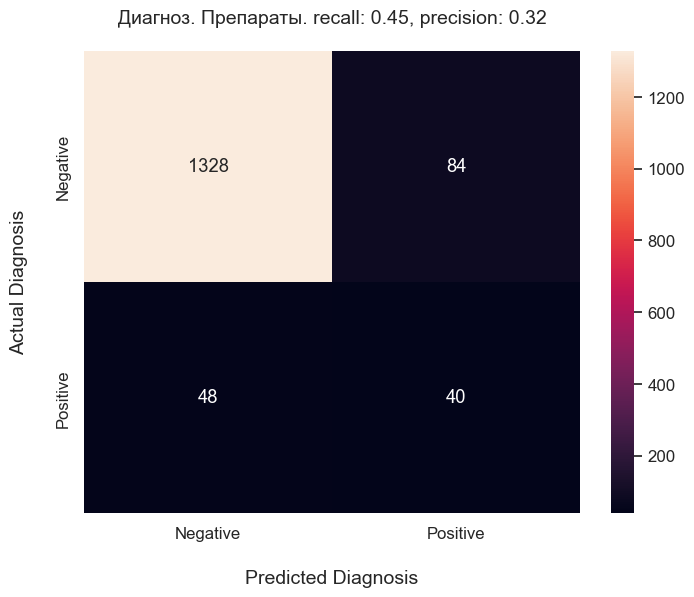

In [5]:
# предобработка результата
predict_proba_one = np.array(pd.Series([x[0] for x in model.predict(test_ds)]), 'float32')
y_pred = np.array(pd.Series([1 if x[0]>0.5 else 0 for x in model.predict(test_ds)]), 'int64')
y_test.reset_index(drop=True)

# проверим модель на эффективность. Выводим матрицу ошибок
recall = ("recall: %.2f" % recall_score(y_test, y_pred))
precision = ("precision: %.2f" % precision_score(y_test, y_pred))

plt.figure(figsize=(8,6), dpi=100)
sns.set(font_scale = 1.1)
ax = sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', )
ax.set_xlabel("Predicted Diagnosis", fontsize=14, labelpad=20)
ax.xaxis.set_ticklabels(['Negative', 'Positive'])
ax.set_ylabel("Actual Diagnosis", fontsize=14, labelpad=20)
ax.yaxis.set_ticklabels(['Negative', 'Positive'])
ax.set_title(f"Диагноз. Препараты. {recall}, {precision}", fontsize=14, pad=20)
plt.show()
